# オートエンコーダ（AE）を用いたノイズ除去
AEを用いて画像のノイズ除去を検討した。使用するデータはmnistを用いた。  
使用するデータを学習データと未知データに分割した。それぞれの役割は下記のようになっている。
- 学習データ：AEを作成するためのデータ
- 未知データ：ノイズを含ませたデータ

今回の検証では、学習データにより作成したモデルが、ノイズとなる未知データに対してどのくらいノイズを除去できているかを検討した。  
さらに、エポック数を増やしたモデルを用いたモデルは、増やしていないモデルに比べ、ノイズをより除去できると仮定して、この2種類のモデルを検証した。  
  
使用した画像データはmnistを用いた。このラベル1の画像のうち、未知データとしてランダムに9枚を選択し、その9枚それぞれにノイズを含ませた。

In [324]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from keras.datasets import mnist
! pip install japanize_matplotlib
from japanize_matplotlib import japanize_matplotlib
japanize_matplotlib.japanize()

## seed値の設定

In [325]:
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

# データの作成

## 学習データの準備

In [326]:
# データのインポートと規格化
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255

# 一次元とfloatタイプを32にする
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

# x_trainとx_test, y_trainとy_testを結合し、x_all, y_allを作成
x_all = np.vstack([x_train, x_test])
y_all = np.hstack([y_train, y_test])

# x_trainとx_testから、「1」だけのデータを取り出しx_allに格納する
images= []
label = 1
for i in range(y_all.shape[0]):
    if y_all[i] == label:
        images.append(x_all[i])
images_array = np.array(images)
print(images_array.shape)

(7877, 784)


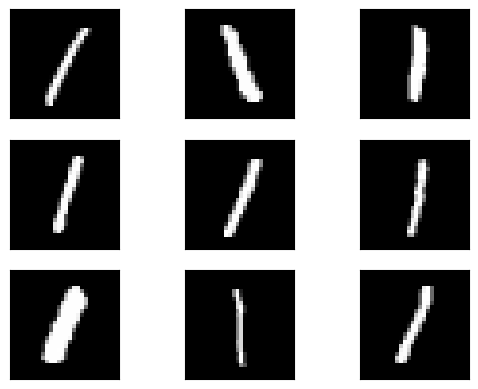

In [327]:
# ランダムに取り出し、画像を確認
perm = np.random.permutation(len(images_array))

fig, axes = plt.subplots(3, 3, subplot_kw={"xticks": (), "yticks": ()})
for i, ax in enumerate(axes.ravel()):
     idx = perm[i]
     image = images_array[idx].reshape(28, 28)
     ax.imshow(image, cmap="gray")


## 未知データの準備
images_arrayから9枚を取り出し未知データを作成する。  
x_allのデータは0～1に規格化されているため、0～1のノイズを入れる。  

作成する未知データとして、下記の3つの要素に分けた。  
- ノイズデータ（小）：画像の1/4にノイズを含ませた画像（3枚）
- ノイズデータ（中）：画像の半分にノイズを含ませた画像（3枚）
- ノイズデータ（大）：画像の全体にノイズを含ませた画像（3枚）  

試しにノイズデータ（小）を1枚作成し可視化する

In [328]:
# 25%ノイズを作成
noise_array = np.zeros(shape=(1, images_array.shape[1])) # (1, 784)の空データを作成
percentile = 0.25                                        # パーセントの設定
perm_noise = np.random.permutation(noise_array.shape[1]) # 空データのどこにノイズを含ませるかを決める
perm_noise_index = perm_noise[0:int(784 * percentile)]   # perm_noiseのうち、25%分のインデックスを取得
for n_idx in perm_noise_index:
    random_noise = np.random.rand()
    noise_array[0, n_idx] = random_noise

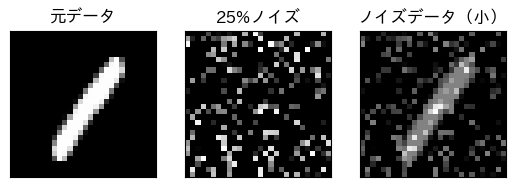

In [329]:
# ノイズデータの選定
noise_idx = [4249, 7634, 6514, 1219, 7858, 7640, 1755, 1057, 7829]

# ノイズデータ（小）を作成
images_noise = images_array[noise_idx[0], :] + noise_array

# 可視化
imgs = [images_array[noise_idx[0], :], noise_array, images_noise]
titles = ["元データ", "25%ノイズ", "ノイズデータ（小）"]

fig, axes = plt.subplots(1, 3, subplot_kw={"xticks": (), "yticks": ()})
for img, title, ax in zip(imgs, titles, axes.ravel()):
    img = img.reshape(28, 28)
    ax.imshow(img, cmap="gray")
    ax.set_title(title)

ノイズデータ（小）、（中）、（大）を作成する。

In [330]:
# n%ノイズデータを作成する関数
def make_noise_image_array(percentile, noise_idx_i):
    noise_array = np.zeros(shape=(1, 784)) # (1, 784)の空データを作成
    perm_noise = np.random.permutation(noise_array.shape[1]) # 空データのどこにノイズを含ませるかを決める
    perm_noise_index = perm_noise[0:int(784 * percentile)]   # perm_noiseのうち、25%分のインデックスを取得
    for n_idx in perm_noise_index:
        random_noise = np.random.rand()
        noise_array[0, n_idx] = random_noise

    # ノイズデータを作成
    images_noise = images_array[noise_idx_i, :] + noise_array

    return noise_array, images_noise

### ノイズデータ（小）を作成

0
1
2
(3, 784)


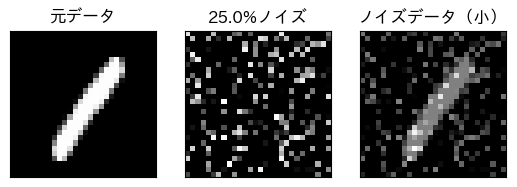

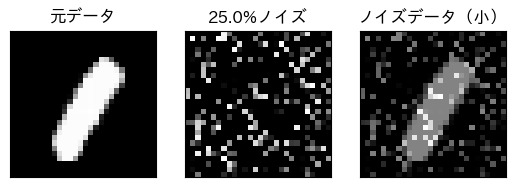

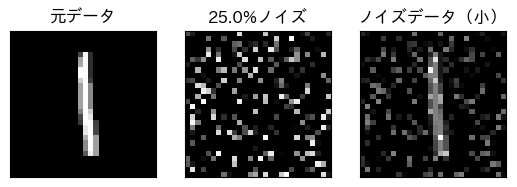

In [331]:
# ノイズデータの選定
noise_idx = [4249, 7634, 6514, 1219, 7858, 7640, 1755, 1057, 7829]

# ノイズデータ（小）を作成
per = 0.25
noise_images_array_lists = []
for i in range(3):
    print(i)
    noise_array, noise_images_array = make_noise_image_array(percentile=per, noise_idx_i=noise_idx[i])

    # 可視化
    imgs = [images_array[noise_idx[i], :], noise_array, noise_images_array]
    titles = ["元データ", f"{per*100}%ノイズ", "ノイズデータ（小）"]

    fig, axes = plt.subplots(1, 3, subplot_kw={"xticks": (), "yticks": ()})
    for img, title, ax in zip(imgs, titles, axes.ravel()):
        img = img.reshape(28, 28)
        ax.imshow(img, cmap="gray")
        ax.set_title(title)

    # 保存
    noise_images_array = noise_images_array.squeeze()
    noise_images_array_lists.append(noise_images_array)

# ノイズデータを保存するためのarrayデータ
images_array_add_noise = np.array(noise_images_array_lists)
print(images_array_add_noise.shape)


### ノイズデータ（中）を作成

3
4
5
(6, 784)


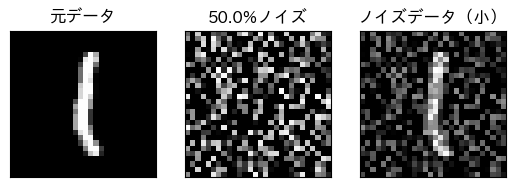

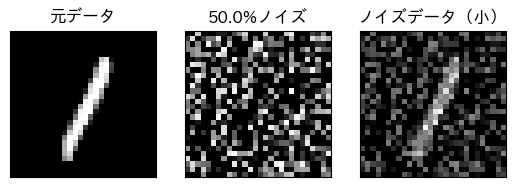

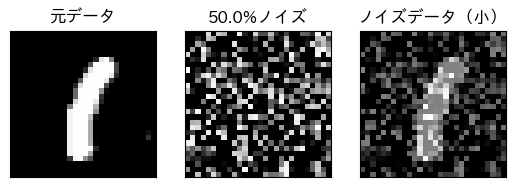

In [332]:
# ノイズデータ（中）を作成
per = 0.50
for i in range(3, 6):
    print(i)
    noise_array, noise_images_array = make_noise_image_array(percentile=per, noise_idx_i=noise_idx[i])

    # 可視化
    imgs = [images_array[noise_idx[i], :], noise_array, noise_images_array]
    titles = ["元データ", f"{per*100}%ノイズ", "ノイズデータ（小）"]

    fig, axes = plt.subplots(1, 3, subplot_kw={"xticks": (), "yticks": ()})
    for img, title, ax in zip(imgs, titles, axes.ravel()):
        img = img.reshape(28, 28)
        ax.imshow(img, cmap="gray")
        ax.set_title(title)

    # 保存
    noise_images_array = noise_images_array.squeeze()
    noise_images_array_lists.append(noise_images_array)

# ノイズデータを保存するためのarrayデータ
images_array_add_noise = np.array(noise_images_array_lists)
print(images_array_add_noise.shape)

### ノイズデータ（大）を作成

6
7
8
(9, 784)


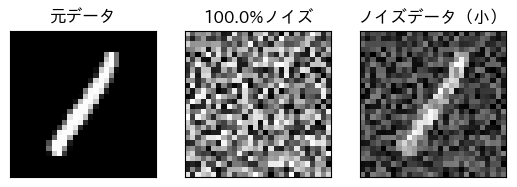

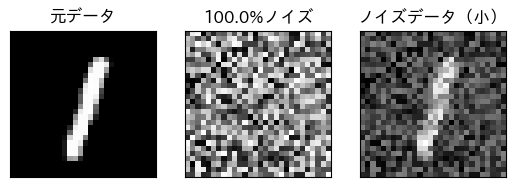

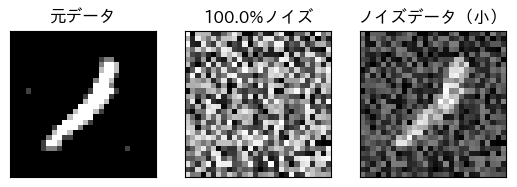

In [333]:
# ノイズデータ（中）を作成
per = 1.0
for i in range(6, 9):
    print(i)
    noise_array, noise_images_array = make_noise_image_array(percentile=per, noise_idx_i=noise_idx[i])

    # 可視化
    imgs = [images_array[noise_idx[i], :], noise_array, noise_images_array]
    titles = ["元データ", f"{per*100}%ノイズ", "ノイズデータ（小）"]

    fig, axes = plt.subplots(1, 3, subplot_kw={"xticks": (), "yticks": ()})
    for img, title, ax in zip(imgs, titles, axes.ravel()):
        img = img.reshape(28, 28)
        ax.imshow(img, cmap="gray")
        ax.set_title(title)

    # 保存
    noise_images_array = noise_images_array.squeeze()
    noise_images_array_lists.append(noise_images_array)

# ノイズデータを保存するためのarrayデータ
images_array_add_noise = np.array(noise_images_array_lists)
print(images_array_add_noise.shape)

ノイズデータは「images_array_add_noise」というndarray型

In [334]:
images_array_add_noise.shape

(9, 784)

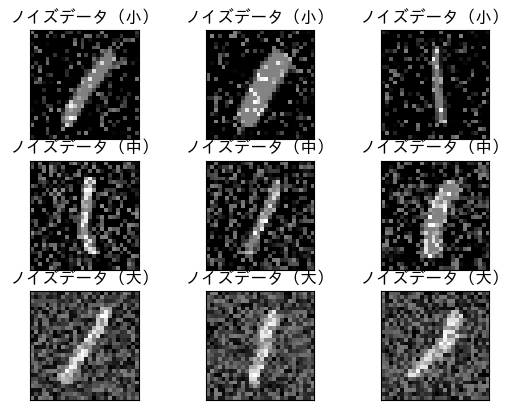

In [335]:
# 確認
fig, axes = plt.subplots(3, 3, subplot_kw={"xticks": (), "yticks": ()})
for i, ax in enumerate(axes.ravel()):
    image = images_array_add_noise[i].reshape(28, 28)
    ax.imshow(image, cmap="gray")
    if (i == 0) | (i == 1) | (i == 2):
        ax.set_title(f"ノイズデータ（小）")
    elif (i == 3) | (i == 4) | (i == 5):
        ax.set_title(f"ノイズデータ（中）")
    elif (i == 6) | (i == 7) | (i == 8):
        ax.set_title(f"ノイズデータ（大）")


## 学習データと未知データの作成
学習データをimages_array_train, 未知データをimages_array_add_noiseとした。  
ただし、学習データをimages_arrayのうち、未知データで作成したデータを除いたものを使用する。

In [336]:
# ノイズデータのインデックスではないインデックスを取得
not_noise_idx = []
for i in range(len(images_array)):
    if i in noise_idx:
        pass
    else:
        not_noise_idx.append(i)

# 学習データと未知データの確認
images_array_train = images_array[not_noise_idx]
print(images_array.shape) # 元データ
print(images_array_train.shape) # 学習データ
print(images_array_add_noise.shape) # 未知データ


(7877, 784)
(7868, 784)
(9, 784)


# AEモデルによる学習と検証

## AEモデルの作成
今回実装するモデルの構造は潜在変数の次元を10とする
```
エンコーダ: 512次元→256次元→64次元→32次元→10次元
デコーダ: 10次元→32次元→64次元→256次元→512次元
```
とする。活性化関数はrelu関数を用いる。ただし、最後はsigmoid関数を用いる。

In [337]:
input_dim = images_array_train.shape[1]
output_dim = images_array_train.shape[1]
latent_dim=10

autoencoder = Sequential()
autoencoder.add(Dense(units=512, activation="relu", input_dim=input_dim))
autoencoder.add(Dense(units=256, activation="relu"))
autoencoder.add(Dense(units=64, activation="relu"))
autoencoder.add(Dense(units=32, activation="relu"))
autoencoder.add(Dense(units=latent_dim))

autoencoder.add(Dense(units=32, activation="relu"))
autoencoder.add(Dense(units=64, activation="relu"))
autoencoder.add(Dense(units=256, activation="relu"))
autoencoder.add(Dense(units=512, activation="relu"))
autoencoder.add(Dense(units=output_dim, activation="sigmoid"))


In [338]:
# 損失関数の定義
def ae_loss(x,y):
    return K.mean(K.sum(-x*K.log(y+1e-2) - (1-x)*K.log(1-y+1e-2), axis = -1)) # 1e-2があまりにも小さすぎるとlossがnanになります

## 学習
学習データの8割を訓練データ、残りを検証データに分けて学習した。  
エポック数は5、バッチサイズは64とした。


In [339]:
# コンパイル
autoencoder.compile(optimizer="adam", loss=ae_loss)
autoencoder.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_140 (Dense)           (None, 512)               401920    
                                                                 
 dense_141 (Dense)           (None, 256)               131328    
                                                                 
 dense_142 (Dense)           (None, 64)                16448     
                                                                 
 dense_143 (Dense)           (None, 32)                2080      
                                                                 
 dense_144 (Dense)           (None, 10)                330       
                                                                 
 dense_145 (Dense)           (None, 32)                352       
                                                                 
 dense_146 (Dense)           (None, 64)              

In [340]:
history = autoencoder.fit(images_array_train, images_array_train
                        , batch_size=64, epochs=5, shuffle=True, validation_split=0.2)

Epoch 1/5
99/99 [==============================] - 7s 49ms/step - loss: 109.7810 - val_loss: 51.5167
Epoch 2/5
99/99 [==============================] - 4s 42ms/step - loss: 48.6710 - val_loss: 45.5792
Epoch 3/5
99/99 [==============================] - 4s 41ms/step - loss: 42.3333 - val_loss: 38.9221
Epoch 4/5
99/99 [==============================] - 5s 49ms/step - loss: 39.9831 - val_loss: 38.5852
Epoch 5/5
99/99 [==============================] - 4s 43ms/step - loss: 39.3646 - val_loss: 37.5303


## モデルの検証
作成したモデルの損失関数の値を可視化する。  
学習するにつれて、学習データと検証データの損失関数の値が近くなるはずだ。

Text(0, 0.5, '損失関数の値')

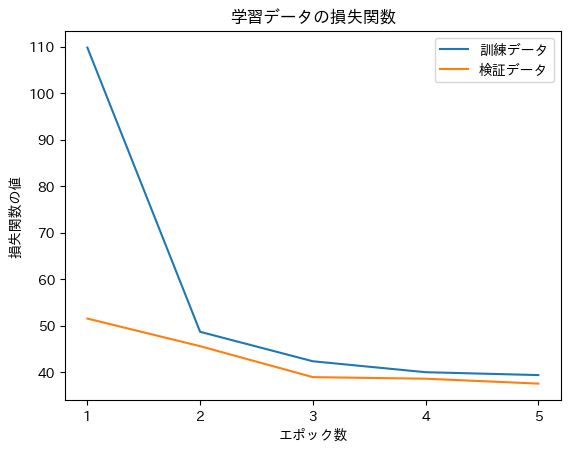

In [341]:
plt.title("学習データの損失関数")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["訓練データ", "検証データ"])
plt.xticks(ticks=np.arange(0, 5, 1), labels=np.arange(1, 6, 1))
plt.xlabel("エポック数")
plt.ylabel("損失関数の値")

データが復元できているかを検証する  
images_array_trainのうち10枚を抜き出し、ちゃんと復元できているかを確認する

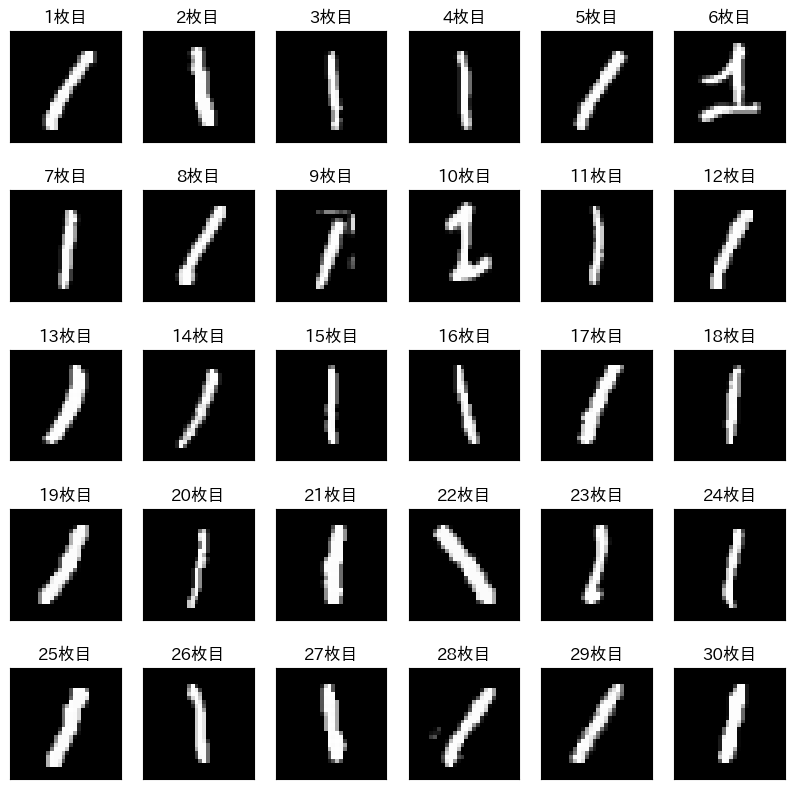

In [342]:
# 元データ
fig, axes = plt.subplots(5, 6, figsize=(10, 10),
                         subplot_kw={"xticks": (), "yticks": ()})
for i, ax in enumerate(axes.ravel()):
    x = images_array_train[i].reshape(28, 28)
    ax.imshow(x, cmap="gray")
    ax.set_title(f"{i+1}枚目")

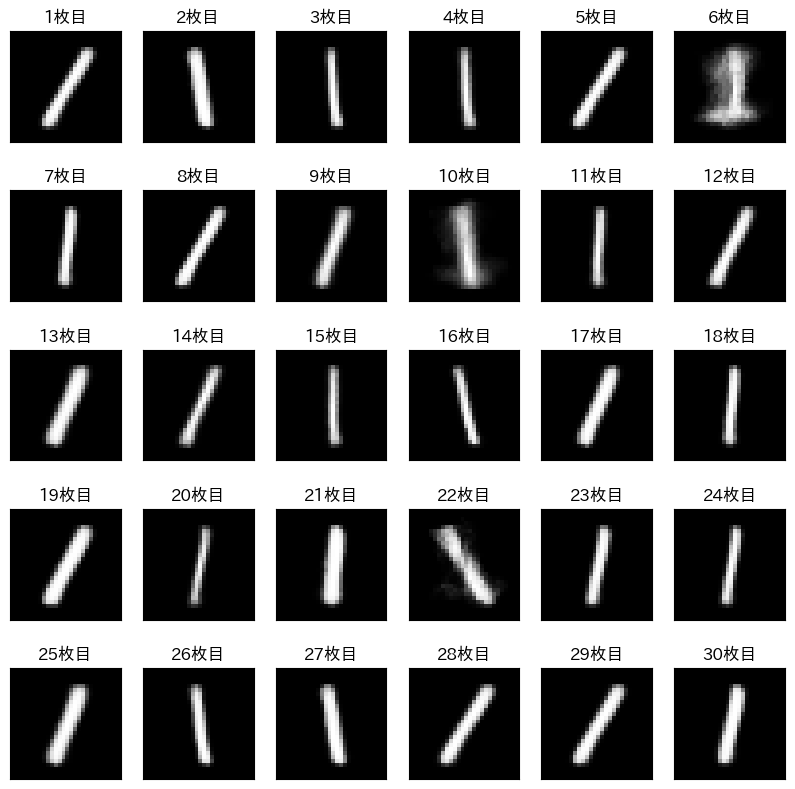

In [343]:
# AEで再現したmnistを表示
# 元データ
fig, axes = plt.subplots(5, 6, figsize=(10, 10),
                         subplot_kw={"xticks": (), "yticks": ()})
for i, ax in enumerate(axes.ravel()):
    x = images_array_train[i].reshape(1, 784)
    y = autoencoder(x).numpy()
    ax.imshow(y.reshape(28, 28), cmap="gray")
    ax.set_title(f"{i+1}枚目")

結果として、ほとんど復元できていることがわかる。  
ただし、6枚目と10枚目は、1の書き方に特徴があり、その影響で復元した画像では  
ぼやけてしまっていることがわかる。

## 検証結果
  今回作成したAEに未知データ（ノイズデータ）を入力させ、どのような予測を出力するかを検証する。  
作成したAEは、ノイズを含んでいないデータで学習しているため、未知データに対する予測は   
ノイズデータの部分を除去したデータを出力するはずだ。

In [344]:
pred_img = autoencoder.predict(images_array_add_noise)
pred_img.shape

1/1 [==============================] - 0s 128ms/step


(9, 784)

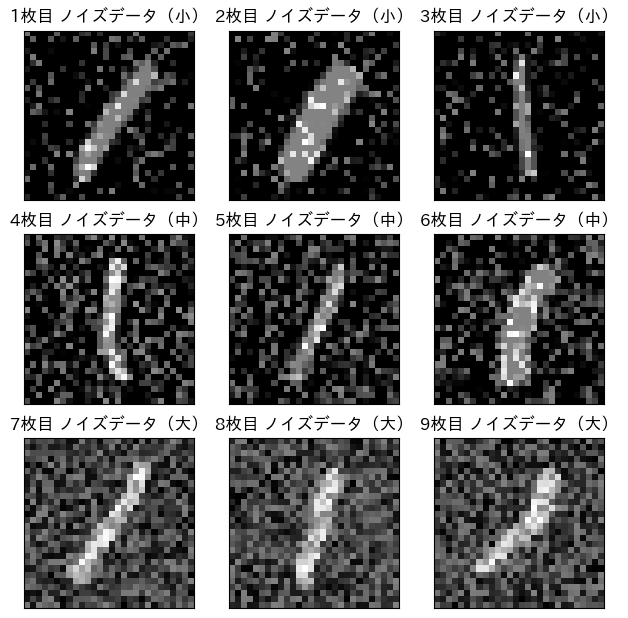

In [345]:
# 元データ
fig, axes = plt.subplots(3, 3, figsize=(7.5, 7.5), subplot_kw={"xticks": (), "yticks": ()})
for i, ax in enumerate(axes.ravel()):
    image = images_array_add_noise[i].reshape(28, 28)
    ax.imshow(image, cmap="gray")
    if (i == 0) | (i == 1) | (i == 2):
        ax.set_title(f"{i+1}枚目 ノイズデータ（小）")
    elif (i == 3) | (i == 4) | (i == 5):
        ax.set_title(f"{i+1}枚目 ノイズデータ（中）")
    elif (i == 6) | (i == 7) | (i == 8):
        ax.set_title(f"{i+1}枚目 ノイズデータ（大）")

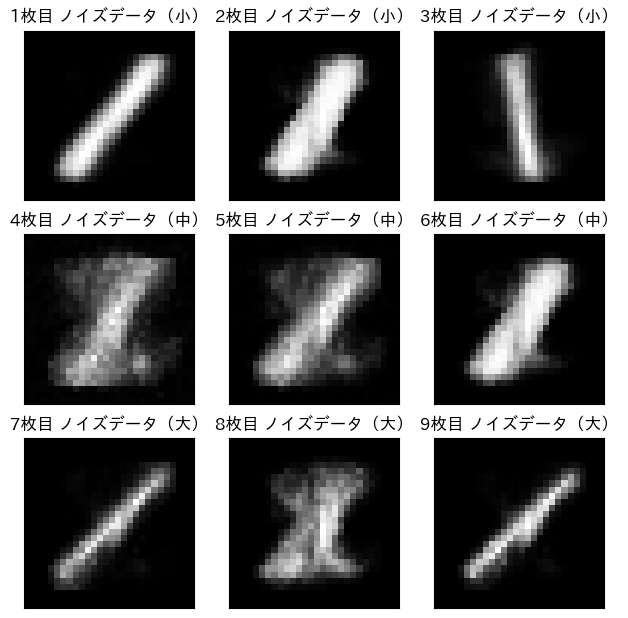

In [346]:
# AEを通したデータ
fig, axes = plt.subplots(3, 3, figsize=(7.5, 7.5), subplot_kw={"xticks": (), "yticks": ()})
for i, ax in enumerate(axes.ravel()):
    image = pred_img[i].reshape(28, 28)
    ax.imshow(image, cmap="gray")
    if (i == 0) | (i == 1) | (i == 2):
        ax.set_title(f"{i+1}枚目 ノイズデータ（小）")
    elif (i == 3) | (i == 4) | (i == 5):
        ax.set_title(f"{i+1}枚目 ノイズデータ（中）")
    elif (i == 6) | (i == 7) | (i == 8):
        ax.set_title(f"{i+1}枚目 ノイズデータ（大）")


### 結果
今回、未知データとして作成したノイズデータを入力させ、作成したモデルにより予測させた。  
結果として、ノイズデータ（小）は綺麗にノイズを削除できていることが分かった。  
一方、ノイズデータ（中）やノイズデータ（大）は、ノイズデータ（小）に比べ、4, 5, 8枚目で  
ノイズを削除できていないことが見受けられた。


# エポック数を増やしたAEモデルによる検証
先ほど作成したモデルのエポック数を増やしたモデルを用いて、ノイズを除去できているか検証した。

In [347]:
input_dim = images_array_train.shape[1]
output_dim = images_array_train.shape[1]
latent_dim=10

autoencoder = Sequential()
autoencoder.add(Dense(units=512, activation="relu", input_dim=input_dim))
autoencoder.add(Dense(units=256, activation="relu"))
autoencoder.add(Dense(units=64, activation="relu"))
autoencoder.add(Dense(units=32, activation="relu"))
autoencoder.add(Dense(units=latent_dim))

autoencoder.add(Dense(units=32, activation="relu"))
autoencoder.add(Dense(units=64, activation="relu"))
autoencoder.add(Dense(units=256, activation="relu"))
autoencoder.add(Dense(units=512, activation="relu"))
autoencoder.add(Dense(units=output_dim, activation="sigmoid"))

# 損失関数の定義
def ae_loss(x,y):
    return K.mean(K.sum(-x*K.log(y+1e-2) - (1-x)*K.log(1-y+1e-2), axis = -1)) # 1e-2があまりにも小さすぎるとlossがnanになります

# コンパイル
autoencoder.compile(optimizer="adam", loss=ae_loss)
history = autoencoder.fit(images_array_train, images_array_train
                        , batch_size=64, epochs=10, shuffle=True, validation_split=0.2)

Epoch 1/10
99/99 [==============================] - 5s 28ms/step - loss: 109.6206 - val_loss: 51.2062
Epoch 2/10
99/99 [==============================] - 3s 29ms/step - loss: 49.0234 - val_loss: 45.6722
Epoch 3/10
99/99 [==============================] - 2s 22ms/step - loss: 42.8904 - val_loss: 38.9992
Epoch 4/10
99/99 [==============================] - 2s 21ms/step - loss: 40.1956 - val_loss: 38.8166
Epoch 5/10
99/99 [==============================] - 2s 21ms/step - loss: 39.5499 - val_loss: 37.4556
Epoch 6/10
99/99 [==============================] - 3s 28ms/step - loss: 36.0211 - val_loss: 33.4713
Epoch 7/10
99/99 [==============================] - 4s 39ms/step - loss: 33.9184 - val_loss: 32.5432
Epoch 8/10
99/99 [==============================] - 3s 28ms/step - loss: 33.0844 - val_loss: 32.1748
Epoch 9/10
99/99 [==============================] - 2s 22ms/step - loss: 32.6510 - val_loss: 31.6557
Epoch 10/10
99/99 [==============================] - 2s 23ms/step - loss: 32.3928 - val_lo

## モデルの検証
結果として、損失関数は訓練データと検証データが近い値になった。  
次にAEにより再現したデータの検証では、エポック数を増やす前に比べ、6枚目と10枚目がより元のデータに再現できていた。

Text(0, 0.5, '損失関数の値')

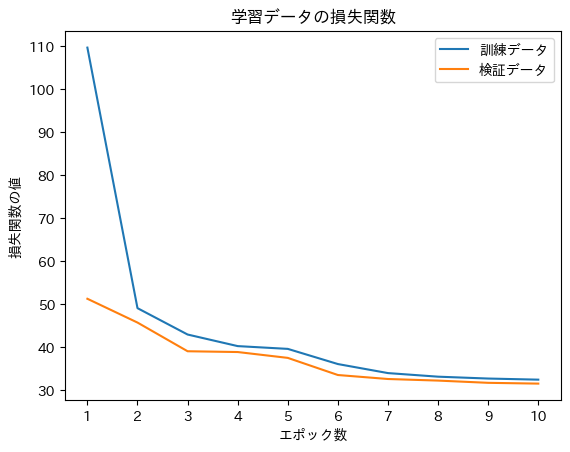

In [348]:
# モデルの精度確認
plt.title("学習データの損失関数")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["訓練データ", "検証データ"])
plt.xticks(ticks=np.arange(0, 10, 1), labels=np.arange(1, 11, 1))
plt.xlabel("エポック数")
plt.ylabel("損失関数の値")

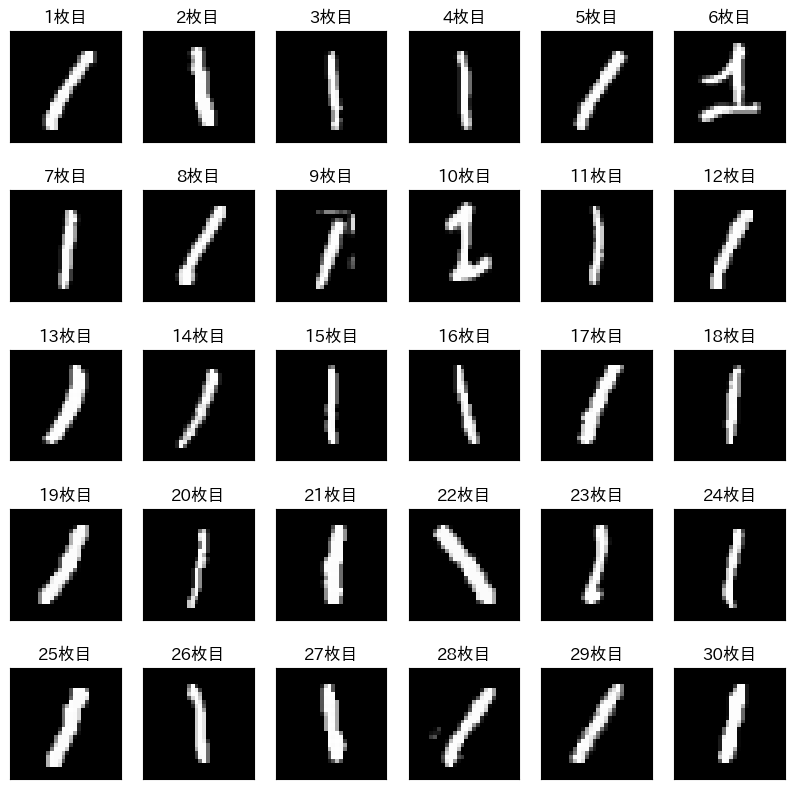

In [349]:
# 元データ
fig, axes = plt.subplots(5, 6, figsize=(10, 10),
                         subplot_kw={"xticks": (), "yticks": ()})
for i, ax in enumerate(axes.ravel()):
    x = images_array_train[i].reshape(28, 28)
    ax.imshow(x, cmap="gray")
    ax.set_title(f"{i+1}枚目")

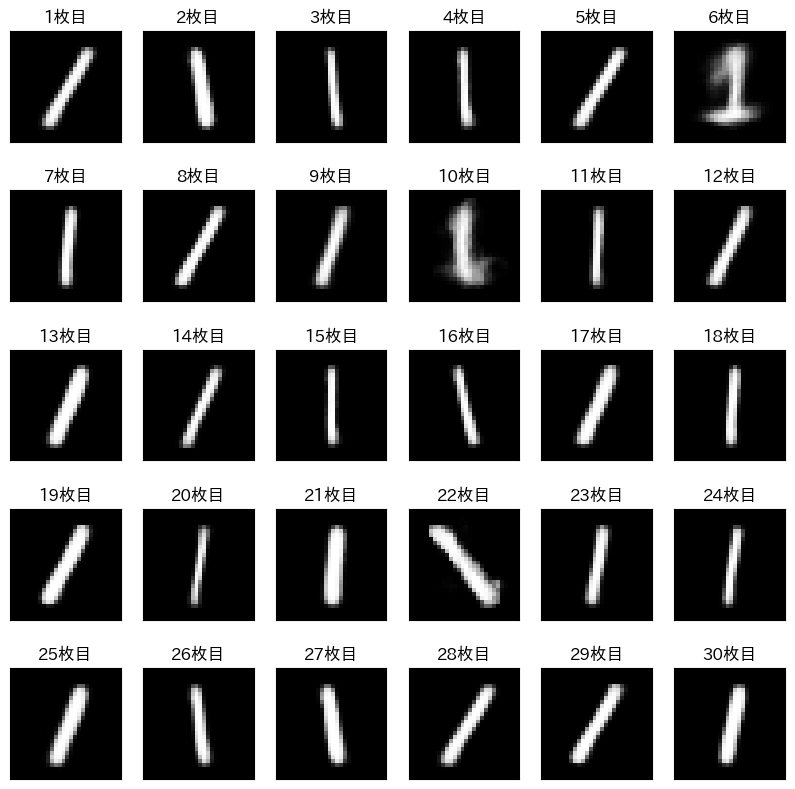

In [350]:
# AEで再現したmnistを表示
# 元データ
fig, axes = plt.subplots(5, 6, figsize=(10, 10),
                         subplot_kw={"xticks": (), "yticks": ()})
for i, ax in enumerate(axes.ravel()):
    x = images_array_train[i].reshape(1, 784)
    y = autoencoder(x).numpy()
    ax.imshow(y.reshape(28, 28), cmap="gray")
    ax.set_title(f"{i+1}枚目")

## 検証結果

In [351]:
# 予測
pred_img = autoencoder.predict(images_array_add_noise)
pred_img.shape

1/1 [==============================] - 0s 185ms/step


(9, 784)

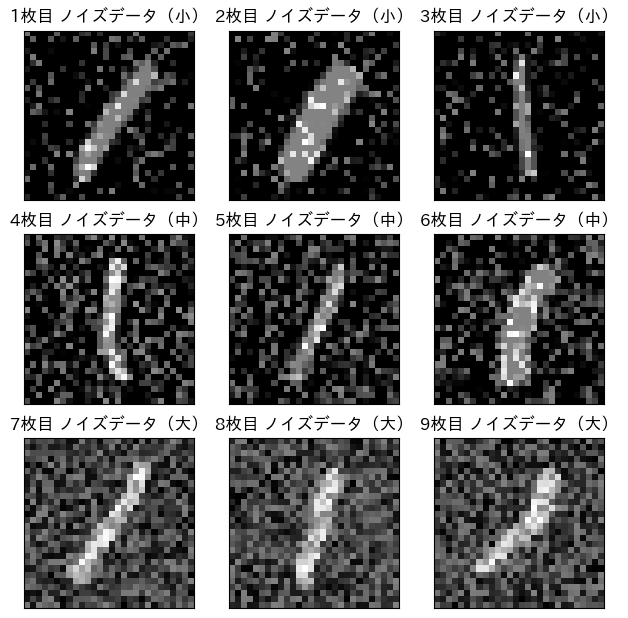

In [352]:
# 元データ
fig, axes = plt.subplots(3, 3, figsize=(7.5, 7.5), subplot_kw={"xticks": (), "yticks": ()})
for i, ax in enumerate(axes.ravel()):
    image = images_array_add_noise[i].reshape(28, 28)
    ax.imshow(image, cmap="gray")
    if (i == 0) | (i == 1) | (i == 2):
        ax.set_title(f"{i+1}枚目 ノイズデータ（小）")
    elif (i == 3) | (i == 4) | (i == 5):
        ax.set_title(f"{i+1}枚目 ノイズデータ（中）")
    elif (i == 6) | (i == 7) | (i == 8):
        ax.set_title(f"{i+1}枚目 ノイズデータ（大）")

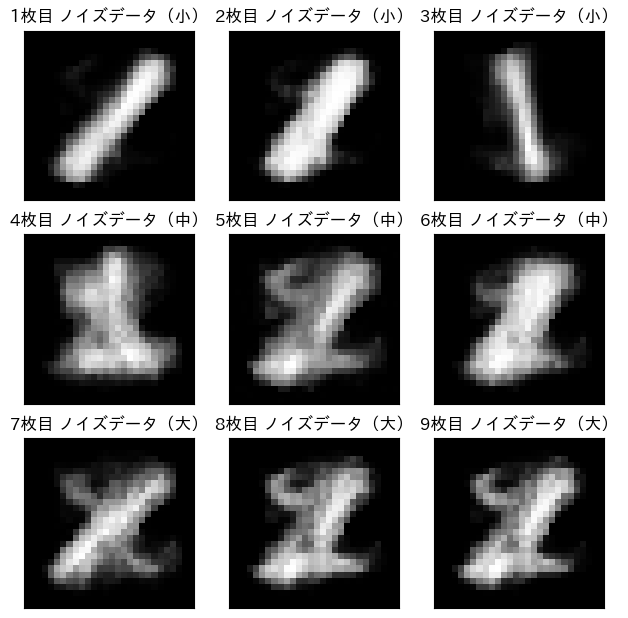

In [353]:
# AEを通したデータ
fig, axes = plt.subplots(3, 3, figsize=(7.5, 7.5), subplot_kw={"xticks": (), "yticks": ()})
for i, ax in enumerate(axes.ravel()):
    image = pred_img[i].reshape(28, 28)
    ax.imshow(image, cmap="gray")
    if (i == 0) | (i == 1) | (i == 2):
        ax.set_title(f"{i+1}枚目 ノイズデータ（小）")
    elif (i == 3) | (i == 4) | (i == 5):
        ax.set_title(f"{i+1}枚目 ノイズデータ（中）")
    elif (i == 6) | (i == 7) | (i == 8):
        ax.set_title(f"{i+1}枚目 ノイズデータ（大）")


### 結果
結果としてエポック数を増やしたモデルによる予測は、エポック数を増やす前に比べ、よりノイズを除去できていないくなっていた。  
特に、ノイズデータ（中）、（大）に関しては全く除去できていないことがわかる。

# 考察
今回、AEを用いて構造を同じにしてエポック数5にしたモデルと10にしたモデルで、ノイズ除去を検討した。  
結果として、エポック数10のモデルによる予測は、エポック数5のモデルに比べ、よりノイズを除去できていないくなっていた。   
この原因は、エポック数を増やすことにより、学習データの特徴をよりとらえてしまったことが考えられる。  
  
このように考えた理由として、エポック数10のモデルによる予測のうち、5, 6, 8 ,9枚目が、元データの6, 10枚目の特徴をとらえた結果を出力していると考えたためだ。  
  
従って、画像のノイズ除去を行うモデルを作る際は、元データに対して学習しすぎないモデルを作成することが重要であると考えられる。

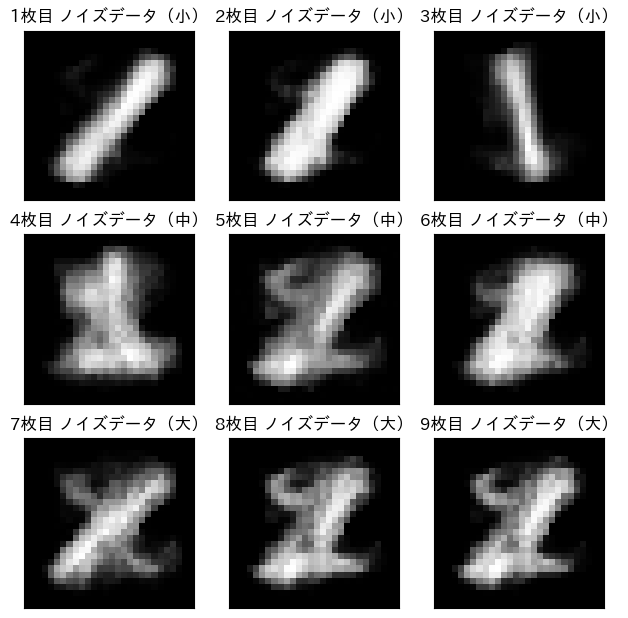

In [354]:
# AEを通したデータ
fig, axes = plt.subplots(3, 3, figsize=(7.5, 7.5), subplot_kw={"xticks": (), "yticks": ()})
for i, ax in enumerate(axes.ravel()):
    image = pred_img[i].reshape(28, 28)
    ax.imshow(image, cmap="gray")
    if (i == 0) | (i == 1) | (i == 2):
        ax.set_title(f"{i+1}枚目 ノイズデータ（小）")
    elif (i == 3) | (i == 4) | (i == 5):
        ax.set_title(f"{i+1}枚目 ノイズデータ（中）")
    elif (i == 6) | (i == 7) | (i == 8):
        ax.set_title(f"{i+1}枚目 ノイズデータ（大）")


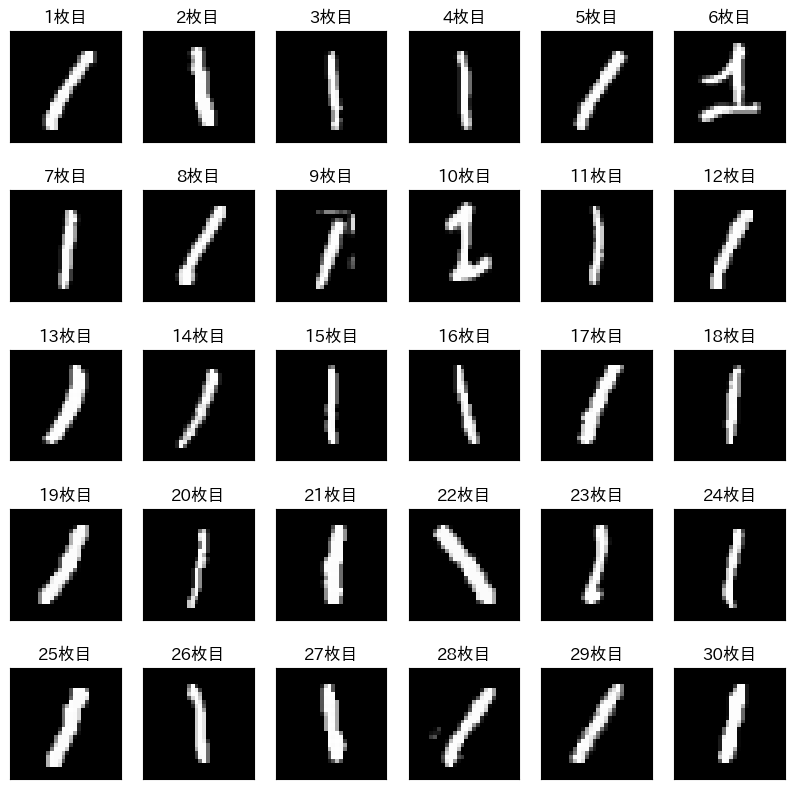

In [355]:
# 元データ
fig, axes = plt.subplots(5, 6, figsize=(10, 10),
                         subplot_kw={"xticks": (), "yticks": ()})
for i, ax in enumerate(axes.ravel()):
    x = images_array_train[i].reshape(28, 28)
    ax.imshow(x, cmap="gray")
    ax.set_title(f"{i+1}枚目")